In [60]:
## Imports and Library Names
import shutil
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import random
import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm
import librosa
import librosa.display
import io
import soundfile as sf
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import ResNet18_Weights
from torch.utils.data import ConcatDataset

from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from sklearn.metrics import accuracy_score


In [25]:
DESTINATION_DIR = "./datasets/Letter-Classification-Data"

TRAIN_DIR = os.path.join(DESTINATION_DIR, "train/images")
TEST_DIR = os.path.join(DESTINATION_DIR, "test/images")
VAL_DIR = os.path.join(DESTINATION_DIR, "valid/images")
print(TRAIN_DIR)


./datasets/Letter-Classification-Data\train/images


In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debashishsau/aslamerican-sign-language-aplhabet-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.20G/4.20G [00:53<00:00, 85.0MB/s]

Extracting model files...


Path to dataset files: C:\Users\cjmij\.cache\kagglehub\datasets\debashishsau\aslamerican-sign-language-aplhabet-dataset\versions\1


In [22]:
KAGGLE_DIR = os.path.join(DESTINATION_DIR, "kaggle")

os.makedirs(KAGGLE_DIR, exist_ok=True)

shutil.move(path, os.path.join(KAGGLE_DIR, os.path.basename(path)))

print("Path to dataset files:", os.path.join(KAGGLE_DIR, os.path.basename(path)))

Path to dataset files: ./datasets/Letter-Classification-Data\kaggle\1


In [90]:
# Source and destination
DEST_DIR = Path("./datasets/Letter-Classification-Data")

SOURCE_DIR = DEST_DIR / "kaggle/1/ASL_Alphabet_Dataset/asl_alphabet_train"
DEST_ROOT = DEST_DIR / "kaggle_split"

TRAIN_KAGGLE_DIR = DEST_ROOT / "train"
TEST_KAGGLE_DIR = DEST_ROOT / "test"

In [ ]:
# Create destination folders
for letter_dir in os.listdir(SOURCE_DIR):
    src_class_path = SOURCE_DIR / letter_dir
    if not src_class_path.is_dir():
        continue

    # Optional filter: only use A–Z
    if letter_dir not in list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"):
        continue

    train_class_path = TRAIN_KAGGLE_DIR / letter_dir
    test_class_path = TEST_KAGGLE_DIR / letter_dir
    train_class_path.mkdir(parents=True, exist_ok=True)
    test_class_path.mkdir(parents=True, exist_ok=True)

    images = os.listdir(src_class_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_imgs = images[:split_idx]
    test_imgs = images[split_idx:]

    for img in train_imgs:
        shutil.copy(src_class_path / img, train_class_path / img)

    for img in test_imgs:
        shutil.copy(src_class_path / img, test_class_path / img)

print("✅ Split complete! Data saved to:", DEST_ROOT)

✅ Split complete! Data saved to: datasets\Letter-Classification-Data\kaggle_split


In [26]:
base_transform = transforms.Compose([
    transforms.ToTensor()
])

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

imagenet_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform1 = transforms.Compose([
    augmentation_transform,
    transforms.Lambda(lambda img: TF.rotate(img, 90)),   # Rotate by 90 degrees
    transforms.ToTensor(),
    imagenet_normalization
])

transform2 = transforms.Compose([
    augmentation_transform,
    transforms.Lambda(lambda img: TF.rotate(img, 180)),  # Rotate by 180 degrees
    transforms.ToTensor(),
    imagenet_normalization
])

transform3 = transforms.Compose([
    augmentation_transform,
    transforms.Lambda(lambda img: TF.rotate(img, 270)),  # Rotate by 270 degrees
    transforms.ToTensor(),
    imagenet_normalization
])

In [46]:
# Custom dataset class for loading images into tensors
class ASLLetterDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Class names: A–Z
        self.classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
        self.class_to_idx = {letter: idx for idx, letter in enumerate(self.classes)}

        for file in os.listdir(image_dir):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                label_char = file[0].upper()  # Get the first letter
                if label_char in self.class_to_idx:
                    self.image_paths.append(os.path.join(image_dir, file))
                    self.labels.append(self.class_to_idx[label_char])
                else:
                    print(f"⚠️ Skipping unknown label: {file}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label
    

# Option 1: Simple transform (e.g., same as test)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    imagenet_normalization
])

train_dataset_org = ASLLetterDataset(TRAIN_DIR, transform=val_transform)
test_dataset  = ASLLetterDataset(TEST_DIR, transform=val_transform)

print("Train Dataset Size:", len(train_dataset_org))
print("Test Dataset Size:", len(test_dataset))
print(f"There are {len(train_dataset_org.classes)} Classes:", train_dataset_org.classes)
print(f"There are {len(test_dataset.classes)} Classes:", test_dataset.classes)

# Create DataLoaders
train_loader_org  = DataLoader(train_dataset_org, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Example: iterate through one batch
images, labels = next(iter(test_loader))
print("Batch image shape:", images.shape)
print("Batch labels shape:", labels.shape)
print(f"Batch labels: {labels}")


Train Dataset Size: 1512
Test Dataset Size: 72
There are 26 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
There are 26 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Batch labels: tensor([12,  7, 19, 10,  6, 22,  7, 21, 23,  1, 25, 12,  6, 13, 19, 21,  6, 23,
         6, 25, 22,  2, 14,  8, 18,  9,  2, 12,  1, 24, 24,  7])


In [91]:
class KaggleASLDataset(Dataset):
    def __init__(self, image_dir, transform=None, allowed_classes=None, max_images_per_class=None, seed=42):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self.classes = sorted([d for d in os.listdir(image_dir)
                               if os.path.isdir(os.path.join(image_dir, d))])

        if allowed_classes:
            self.classes = [cls for cls in self.classes if cls in allowed_classes]

        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        random.seed(seed)

        for cls in self.classes:
            cls_path = os.path.join(image_dir, cls)
            image_files = [f for f in os.listdir(cls_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
            random.shuffle(image_files)

            if max_images_per_class:
                image_files = image_files[:max_images_per_class]

            for img_file in image_files:
                self.image_paths.append(os.path.join(cls_path, img_file))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label
    

allowed_classes = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")

kaggle_train = KaggleASLDataset(
    TRAIN_KAGGLE_DIR,
    transform=val_transform,
    allowed_classes=allowed_classes,
    max_images_per_class=100
)
kaggle_test = KaggleASLDataset(
    TEST_KAGGLE_DIR,
    transform=val_transform,
    allowed_classes=allowed_classes,
    max_images_per_class=50
)

print("Train Dataset Size:", len(kaggle_train))
print("Test Dataset Size:", len(kaggle_test))
print(f"There are {len(kaggle_train.classes)} Classes:", kaggle_train.classes)
print(f"There are {len(kaggle_test.classes)} Classes:", kaggle_test.classes)

# Create DataLoaders
train_loader_kaggle  = DataLoader(kaggle_train, batch_size=32, shuffle=True)
test_loader_kaggle  = DataLoader(kaggle_test, batch_size=32, shuffle=True)

# Example: iterate through one batch
images, labels = next(iter(test_loader_kaggle))
print("Batch image shape:", images.shape)
print("Batch labels shape:", labels.shape)
print(f"Batch labels: {labels}")

Train Dataset Size: 2600
Test Dataset Size: 1300
There are 26 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
There are 26 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Batch labels: tensor([25, 23,  0,  6, 12, 15,  6, 13, 12, 18, 22,  5, 17, 24,  3,  5, 19, 20,
        17, 23, 20, 22,  2,  2, 24, 22, 10, 23, 12,  2, 23,  2])


In [ ]:
# combined_train = ConcatDataset([train_dataset_org, kaggle_train])
# combined_test  = ConcatDataset([test_dataset, kaggle_test])

# print("Train Dataset Size:", len(combined_train))
# print("Test Dataset Size:", len(combined_test))
# print(f"There are {len(combined_train.classes)} Classes:", combined_train.classes)
# print(f"There are {len(combined_test.classes)} Classes:", combined_test.classes)

# # Create DataLoaders
# train_loader_combined  = DataLoader(combined_train, batch_size=32, shuffle=True)
# test_loader_combined  = DataLoader(combined_test, batch_size=32, shuffle=True)

# # Example: iterate through one batch
# images, labels = next(iter(combined_train))
# print("Batch image shape:", images.shape)
# print("Batch labels shape:", labels.shape)
# print(f"Batch labels: {labels}")

Train Dataset Size: 166411
Test Dataset Size: 41310


AttributeError: 'ConcatDataset' object has no attribute 'classes'

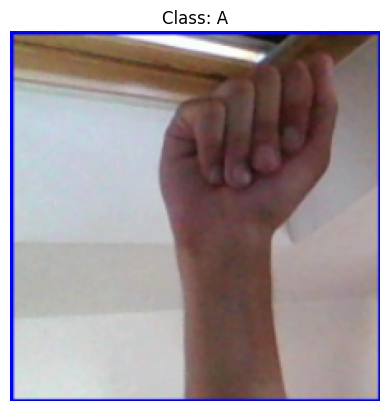

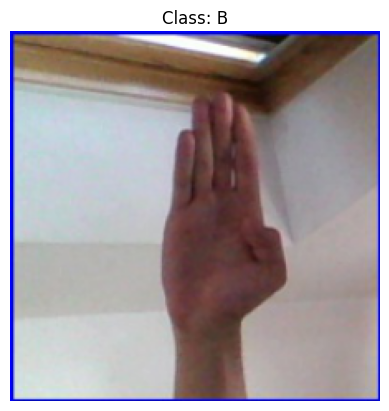

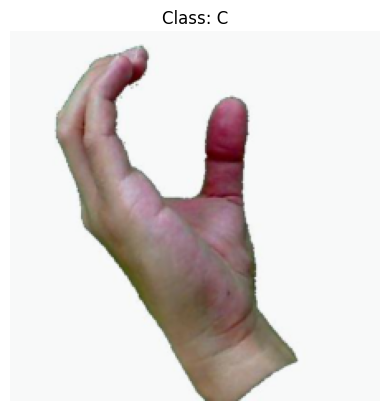

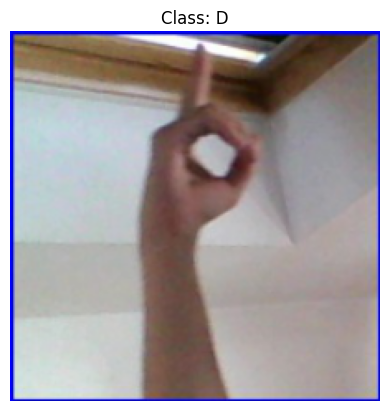

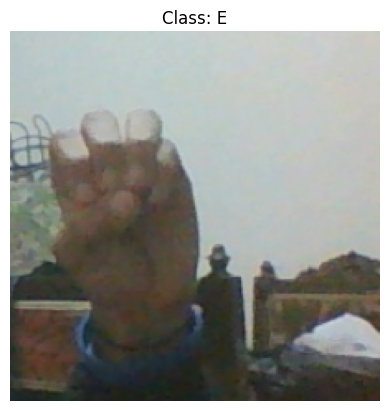

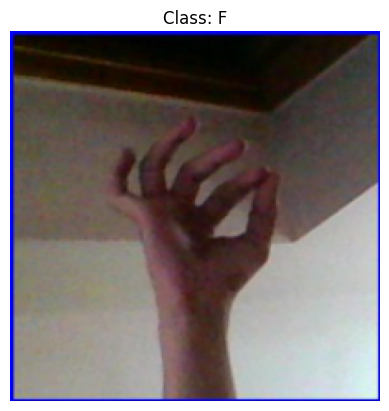

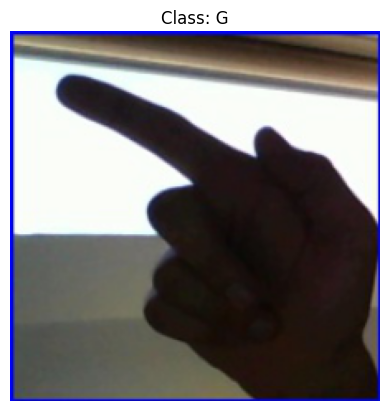

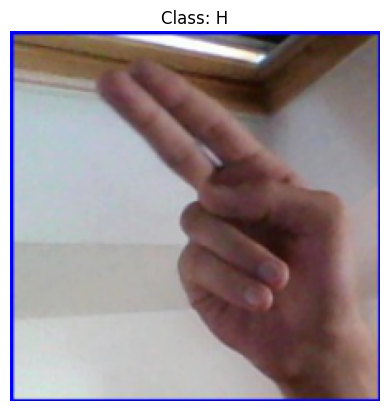

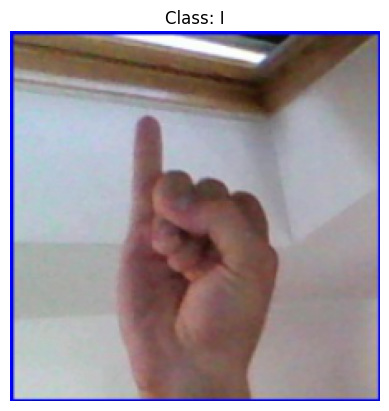

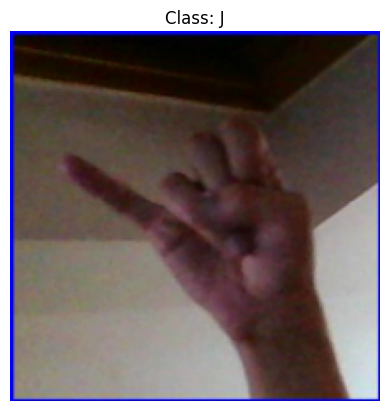

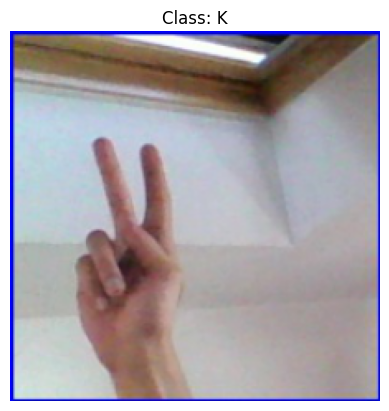

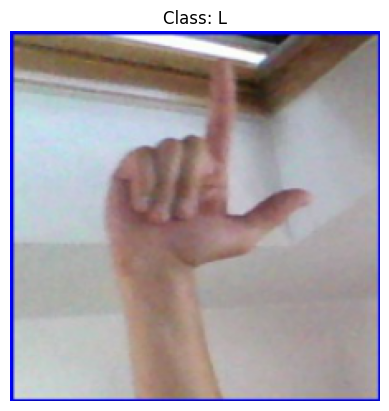

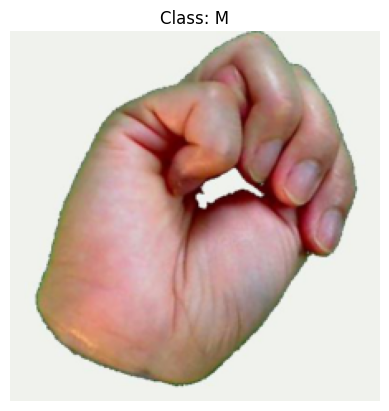

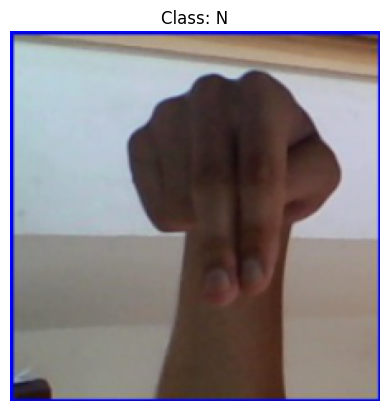

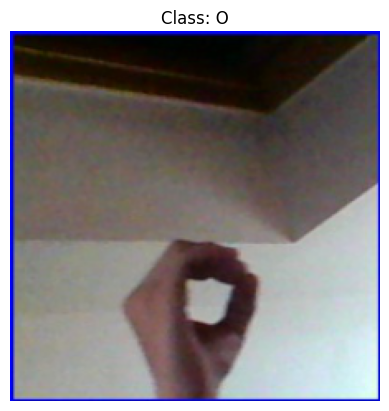

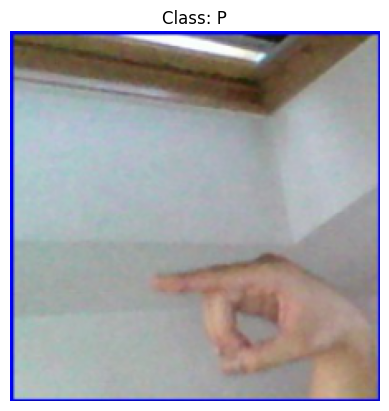

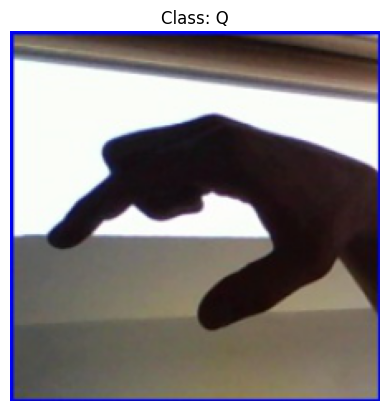

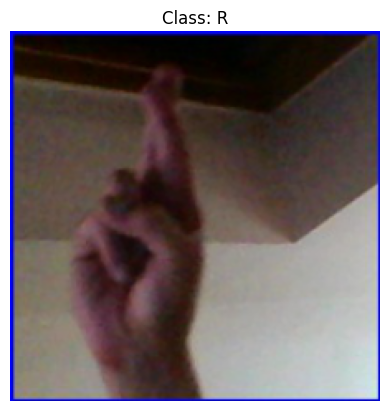

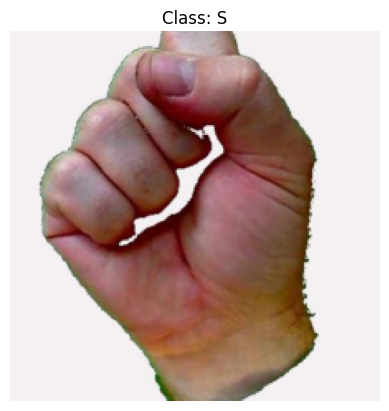

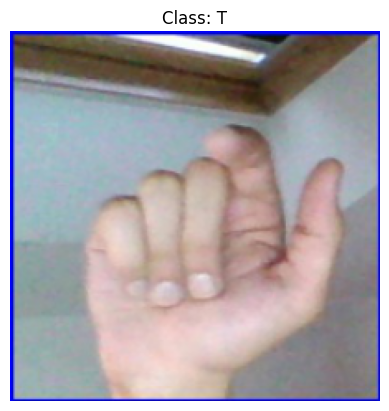

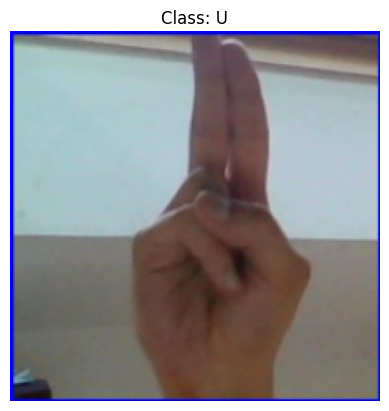

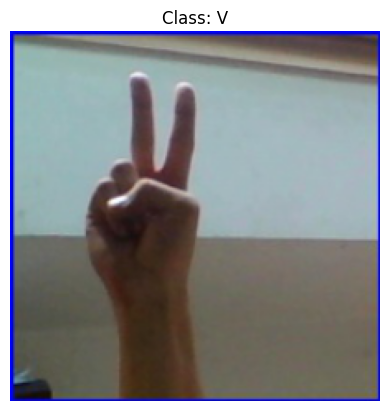

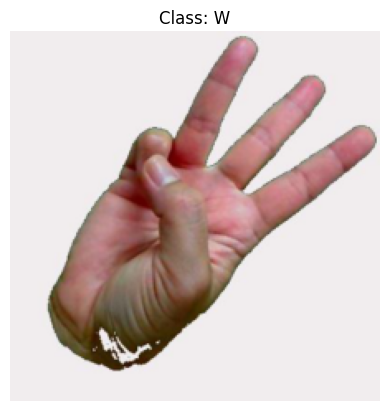

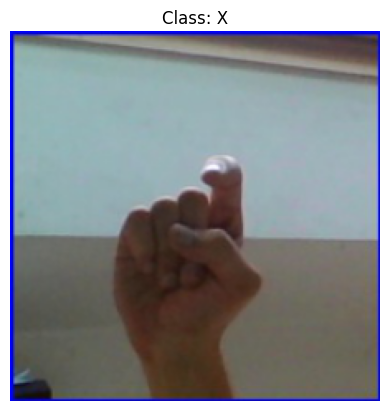

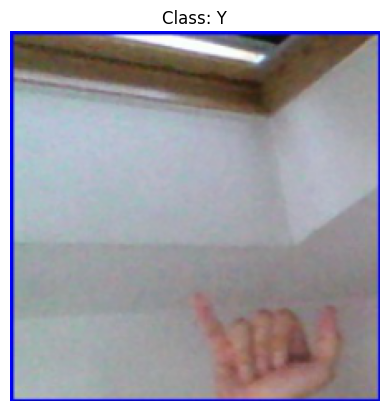

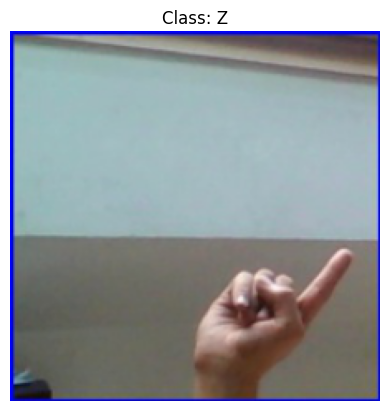

In [92]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    """Denormalize a tensor image."""
    # Convert mean and std to tensors and reshape them for broadcasting
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean

# Instantiate the conversion transform
to_pil = ToPILImage()

dataset = kaggle_test  # or test_dataset, etc.

# Track one image per class
seen_classes = set()
class_name_map = dataset.classes  # ['A', 'B', ..., 'Z']

for i in range(len(dataset)):
    img_tensor, label = dataset[i]
    label_char = class_name_map[label]

    if label_char not in seen_classes:
        seen_classes.add(label_char)

        # Denormalize
        img_tensor_denorm = denormalize(img_tensor, mean, std)
        img = to_pil(img_tensor_denorm)

        # Save and plot
        # filename = f"class_{label_char}.png"
        # img.save(filename)
        # print(f"✅ Saved: {filename}")

        plt.imshow(img)
        plt.title(f"Class: {label_char}")
        plt.axis("off")
        plt.show()

    if len(seen_classes) == len(class_name_map):  # All 26 letters collected
        break


In [30]:
# train_dataset_total = ConcatDataset([train_dataset_org, train_dataset_aug_01, train_dataset_aug_02, train_dataset_aug_03])

# print("Test Dataset Size:", len(train_dataset_total))
# # print(f"There are {len(train_dataset_total.classes)} Classes:", train_dataset_total.classes)

# train_loader_total = DataLoader(train_dataset_total, batch_size=32, shuffle=True)

# # Example: iterate through one batch
# images, labels = next(iter(train_loader_total))
# print("Batch image shape:", images.shape)
# print("Batch labels shape:", labels.shape)
# print(f"Batch labels: {labels}")

Test Dataset Size: 6048
Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Batch labels: tensor([ 9,  6, 25, 23,  4, 22,  5, 13, 18,  5,  6,  0,  8,  4, 21,  7,  3, 22,
        20, 25,  9,  8,  6,  9, 11,  4, 23,  9, 11, 12,  0, 11])


In [93]:
# Load pretrained model
res_net_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Step 1: Freeze all layers
for param in res_net_model.parameters():
    param.requires_grad = False

# Step 2: Unfreeze deeper layers
for name, param in res_net_model.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True

# Step 3: Replace final FC classifier
res_net_model.fc = nn.Sequential(
    nn.Linear(res_net_model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, len(kaggle_train.classes))  # A-Z
)

# Unfreeze FC layer (if needed again)
for param in res_net_model.fc.parameters():
    param.requires_grad = True

# Step 4: Define optimizer to only update trainable layers
trainable_params = filter(lambda p: p.requires_grad, res_net_model.parameters())
optimizer = optim.Adam(trainable_params, lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


# Optional: learning rate scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Step 5: Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_net_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [86]:
def train_loop(dataloader, model, criterion, optimizer):
    train_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    for i, batch in enumerate(dataloader):
        # Good practice: set model to training mode
        model.train()

        X, y = batch
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = criterion(y_pred, y)

        # Accumulate stats
        train_loss += loss.item()
        correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = train_loss / num_batches
    avg_acc = correct / size

    return avg_loss, avg_acc


def test_loop(dataloader, model, criterion):
    model.eval()  # Set the model to evaluation mode
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += criterion(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = test_loss / num_batches
    avg_acc = correct / size

    return avg_loss, avg_acc


In [82]:
from IPython import display

def plot_training(train_loss, test_loss, train_acc, test_acc):
    fig = plt.figure(1, figsize=(12, 6))
    plt.clf()

    ax1 = fig.add_subplot(1, 2, 1) # (Rows, Columns, Position)
    ax2 = fig.add_subplot(1, 2, 2) # (Rows, Columns, Position)
    epochs = [int(i+1) for i in range(len(train_loss))]

    ax1.set_title('Training and Testing Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (Categorical Cross Entropy)')
    ax1.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle=':')
    ax1.plot(epochs, test_loss, label='Test Loss', marker='o', linestyle=':')
    ax1.legend()

    ax2.set_title('Training and Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(epochs, train_acc, label='Train Acc', marker='o', linestyle=':')
    ax2.plot(epochs, test_acc, label='Test Acc', marker='o', linestyle=':')
    ax2.legend()
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

KeyboardInterrupt: 

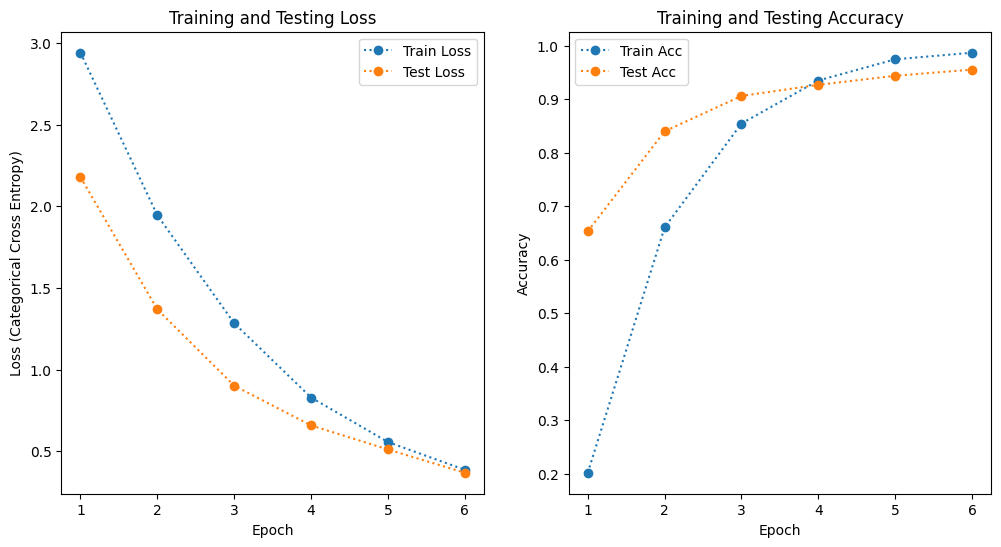

In [94]:
# Define some constants
EPOCH = 30

train_loss = []
train_acc = []
test_loss = []
test_acc = []

# Epoch loop - (Pytorch basics refers to this entire loop as the training loop)
for epoch in range(EPOCH):
    # epoch_train_loss, epoch_train_acc = train_loop(train_loader_total, res_net_model, res_net_criterion, res_net_optimizer)
    # epoch_test_loss, epoch_test_acc = test_loop(test_loader, res_net_model, res_net_criterion)
    
    epoch_train_loss, epoch_train_acc = train_loop(train_loader_kaggle, res_net_model, criterion, optimizer)
    epoch_test_loss, epoch_test_acc = test_loop(test_loader_kaggle, res_net_model, criterion)
    
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    # Print the test loss and accuracy for tracking
    print(f"Epoch {epoch + 1}/{EPOCH} - Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}")

    plot_training(train_loss, test_loss, train_acc, test_acc)


print("✅ Training completed!")

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import numpy as np

res_net_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = res_net_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (26).

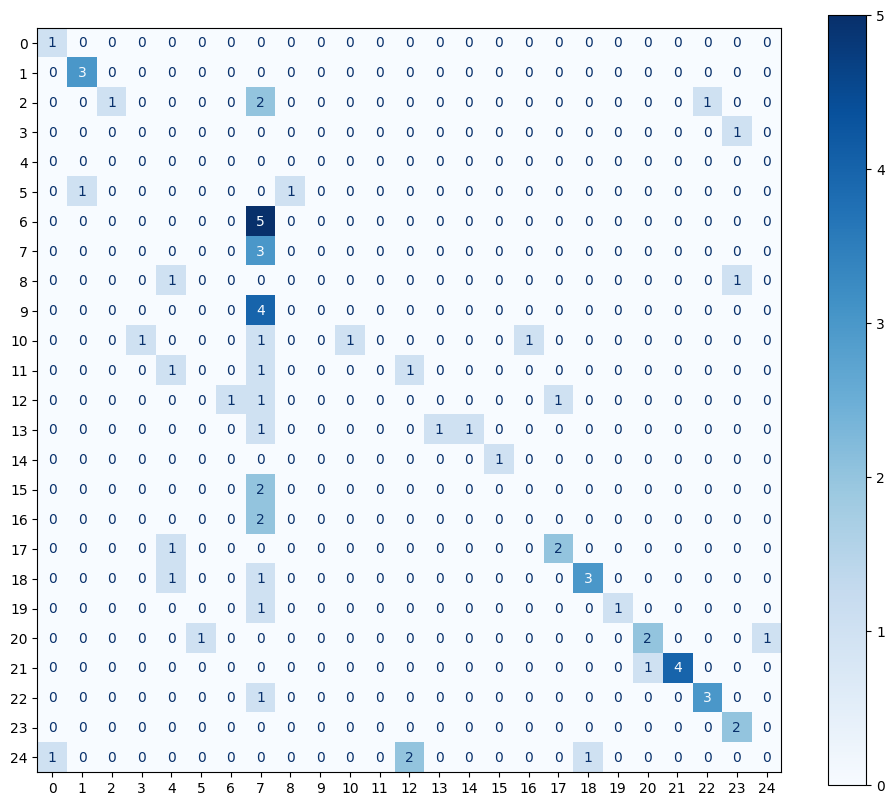

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Map indices back to class letters
class_labels = train_dataset_org.classes  # e.g., ['A', 'B', ..., 'Z']

# Plot the matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues', ax=ax)
plt.title("ASL Letter Classification - Confusion Matrix")
plt.tight_layout()
plt.show()


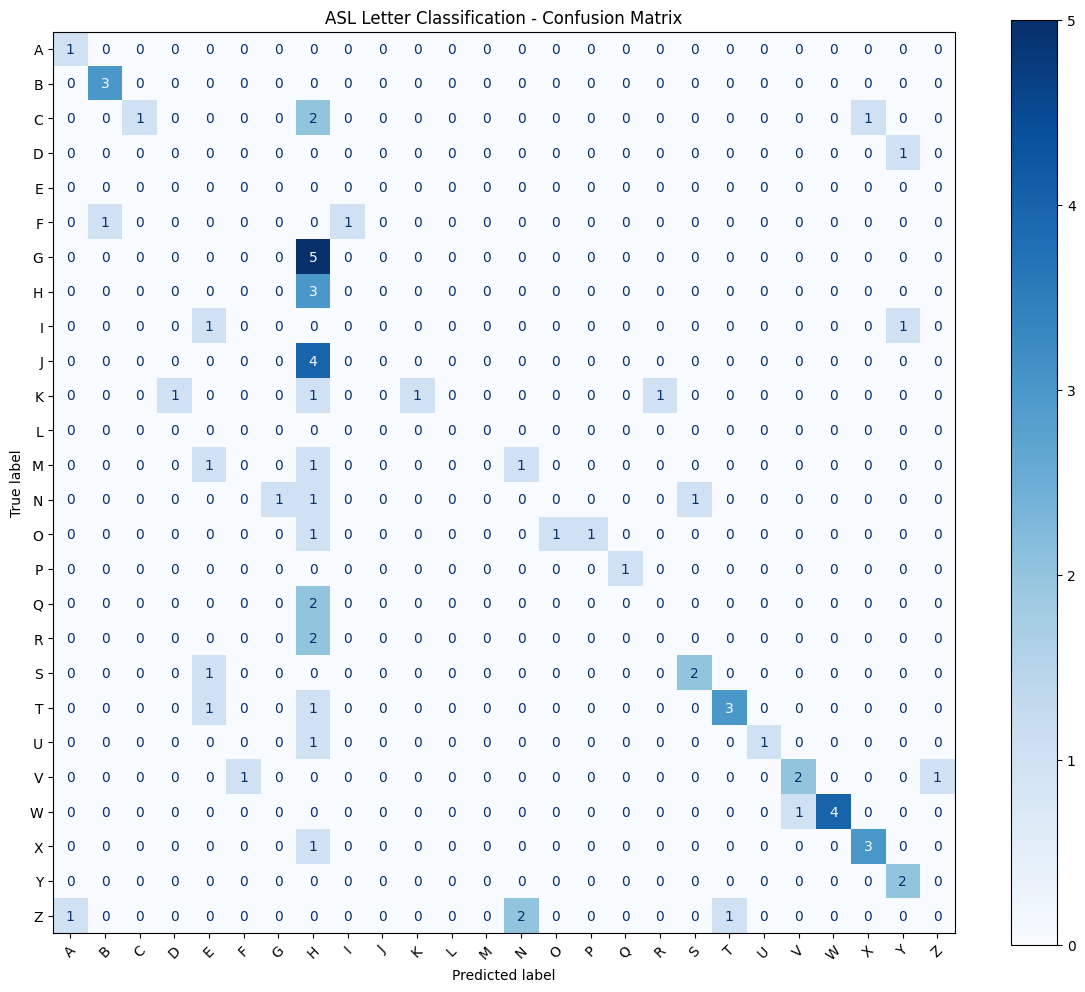

Classes not predicted at all: ['J', 'L', 'M']


In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = train_dataset_org.classes  # ['A', ..., 'Z']
label_indices = list(range(len(class_labels)))  # [0, 1, ..., 25]

# Force matrix to include all classes
cm = confusion_matrix(all_labels, all_preds, labels=label_indices)

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues', ax=ax)
plt.title("ASL Letter Classification - Confusion Matrix")
plt.tight_layout()
plt.show()


pred_classes = set(all_preds)
missing_classes = set(label_indices) - pred_classes
print("Classes not predicted at all:", [class_labels[i] for i in missing_classes])


In [102]:
device = torch.device("cpu")
res_net_model.to(device)

torch.save(res_net_model.state_dict(), "letter_classifier_v1.pt")
print("✅ Model saved as 'letter_classifier_v1.pt'")

✅ Model saved as 'letter_classifier_v1.pt'
